In [7]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 25 17:11:08 2019

@author: mgelman
"""
#fafe
import csv
import itertools
import operator
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import graphviz
from scipy.sparse import hstack
from sklearn import tree
import pydot
import pydotplus
from sklearn.externals.six import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
path = os.path.join(os.path.expanduser("~"), "Documents", "lowe_house_price_prediction", "yelp_dataset")

In [9]:
# import data
path = os.path.join(os.path.expanduser("~"), "Documents", "lowe_house_price_prediction", "yelp_dataset")
#sys.path.insert(0, path)
#sys.path.insert(0, "C:\Users\mgelman\AppData\Local\Continuum\anaconda2\Library\bin\graphviz")

# STEP 1: LOADING IN DATA

# LOAD BUSINESS DATA
inputfile = os.path.join(path, "business.json")
business_data = pd.read_json(inputfile, lines=True)
# keep a subset of variables
business_data = business_data[['business_id', 'postal_code', 'state', 'categories']]
# trim the category text
business_data['categories'] = business_data['categories'].str.slice(stop=50)
business_data['categories'] = business_data['categories'].str.encode('ascii', errors='coerce')
#business_data['categories'] = business_data['categories'].str.replace('&', '')
# convert postal code to integers (will get rid of non-us zipcodes)
business_data['postal_code'] = pd.to_numeric(business_data['postal_code'], errors='coerce')
business_data.dropna(inplace=True)

In [10]:
# LOAD IN REVIEW DATA (use unix command top to create a smaller version of the dataset)
# head -n NUMBEROFLINES file.json > mynewfile.json
# TO GET SPECIFIC YEAR
# grep -E '201[0|1|2]' review.json > review_2010-2012.json
# inputfile=os.path.join(path,"review.json")
inputfile = os.path.join(path, "review_10k.json")
outputfile = os.path.join(path, "review.pkl")
review_data = pd.read_json(inputfile, lines=True)
# only keep business_id, date, stars, text
review_data = review_data[['business_id', 'date', 'stars', 'text']]
# take out #s
review_data['text'] = review_data['text'].str.replace('[0-9]', '')

# vectorizer = TfidfVectorizer(ngram_range=(1, 1),
#                             stop_words='english',
#                             min_df=30)
# X_test= vectorizer.fit_transform(review_data['text'])
# names=vectorizer.get_feature_names()

In [16]:
inputfile = os.path.join(path, "Zip_Zhvi_AllHomes.csv")
# zillow_data = pd.read_csv(inputfile, header=0, quoting=3)
zillow_data = pd.read_csv(inputfile, encoding='latin-1')
#zillow_data = zillow_data.head(100)
# Drop some columns
zillow_data.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1, inplace=True)
# convert to long
zillow_data = pd.melt(zillow_data, id_vars='RegionName', value_vars=list(zillow_data.columns.values)[1:])
# generate datetime
zillow_data['date'] = pd.to_datetime(zillow_data['variable'])
zillow_data['year'] = zillow_data['date'].dt.year
# get yearly mean
zillow_yearly_avg = zillow_data.groupby(['RegionName', 'year'])['value'].mean().reset_index()

# %% Merge everyting together

# First merge the yelp data to get zipcode
yelp_merged = review_data.merge(business_data, left_on='business_id', right_on='business_id', how='left',
                                validate="m:1")
yelp_merged['year'] = pd.to_datetime(yelp_merged['date']).dt.year

# merge yelp with zillow
final_data = yelp_merged.merge(zillow_yearly_avg, left_on=['postal_code', 'year'], right_on=['RegionName', 'year'],
                               how='left', validate="m:1")
final_data.dropna(inplace=True)

csv_file_name = os.path.join(path, "yelp_zillow.tsv")
final_data[['year', 'stars', 'postal_code', 'state', 'value']].to_csv(csv_file_name, sep='\t', encoding='utf-8',
                                                                      index=False, quoting=csv.QUOTE_NONE)

In [17]:
type(final_data)

pandas.core.frame.DataFrame

In [19]:
# %% create differences


# First aggregate to zip year
# create the dictionary for the collapse (mapping from var to agg type)

# group by creates a mapping from the user_id to the row index. Ie, user 1 maps to rows 4,5,6, user 2 maps to rows 7,8,9.
data_group = final_data.groupby(['postal_code', 'year'], as_index=False)

# aggregate in groups depending on the var type
# group 1: numerical variables
mean = ['value', 'stars']

# group 2: retain all strings
all = ['text']

# group 3: ID vars: like state
first = ['state']

# create the dictionary for the collapse (mapping from var to agg type)
d = {}
d_agg_type = {'first': first,
              np.nanmean: mean,
              lambda x: " ".join(x): all}

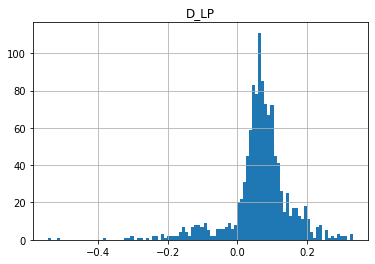

In [23]:
for key, value in d_agg_type.items():
    for col in value:
        d.update({col: key})

# collapse data
final_data_collapsed = data_group.agg(d)

# create log prices
final_data_collapsed['log_price'] = np.log(final_data_collapsed['value'])

# NEED TO SORT TO GET DIFF
final_data_collapsed.sort_values(['postal_code', 'year'], inplace=True)

# convert words to word differences
vectorizer = TfidfVectorizer(ngram_range=(1, 1),
                             stop_words='english',
                             min_df=30)
X_test = vectorizer.fit_transform(final_data_collapsed['text'])

# add the zipcode and year to the words
word_df = pd.concat([final_data_collapsed[['postal_code', 'year']], pd.DataFrame(X_test.todense())], axis=1)
# take the difference
word_df = word_df.groupby(['postal_code']).diff()
# only keep the ones
word_df = word_df.loc[word_df['year'] == 1]
# drop the column and covert back to sparse matrix
word_df.drop(['year'], axis=1, inplace=True)
X_words = scipy.sparse.csr_matrix(word_df.values)

# sort by postal_code,year
final_data_collapsed[['D_LP', 'D_stars', 'D_year']] = final_data_collapsed.groupby(['postal_code'])[
    'log_price', 'stars', 'year'].diff()
# only keep if the difference in year is 1. Or else we are missing data
final_data_collapsed = final_data_collapsed.loc[final_data_collapsed['D_year'] == 1]  # type: object

# Create P_LD categories
final_data_collapsed['P_LD_CAT'] = pd.qcut(final_data_collapsed['D_LP'].values, 5).codes
# confirm the correct split
final_data_collapsed['P_LD_CAT'].value_counts(normalize=True, sort=False)
# log price describe
final_data_collapsed['D_LP'].describe()
# state
final_data_collapsed['state'].value_counts(normalize=True, sort=True)
# histogram
final_data_collapsed.hist(column='D_LP', bins=100)
plt.show()
del review_data, business_data, zillow_data

In [24]:
# use one hot encoding
# final_data = pd.concat([final_data,pd.get_dummies(final_data['categories'])],axis=1)

# test=pd.get_dummies(final_data['categories'])

# %% Create testing,training dataset

# data.to_pickle(outputfile)

# define y as the stars and X as text
# y_data=final_data['value']
y_data = final_data_collapsed['P_LD_CAT']
# X_data=final_data[['stars','text']]
# X_data=final_data[['stars','text','categories']]
X_data = final_data_collapsed[['D_stars']]
# print y_data.value_counts(normalize=True, sort=False)

# split into training and test
X_train, X_test, y_train, y_test, X_words_train, X_words_test = train_test_split(
    X_data, y_data, X_words, test_size=0.25, random_state=1234)

vocab = vectorizer.get_feature_names()
vocab_str = [str(x.encode('utf-8')) for x in vocab]

# Add in stars and yelp categories as features
X_tr = hstack([X_words_train, np.matrix(X_train)])
X_te = hstack([X_words_test, np.matrix(X_test)])

# %%

# falsification test
# y_train=y_train.sample(frac=1)

# Use the tree clasifier
# clf = DecisionTreeRegressor(max_leaf_nodes=15)
clf = DecisionTreeClassifier()
# clf = DecisionTreeClassifier()
# clf = DecisionTreeRegressor()
# clf = RandomForestClassifier(
#                n_estimators=128,
#                n_jobs=-1,
#                verbose=1)

# clf = DecisionTreeClassifier(max_leaf_nodes=15)

clf = clf.fit(X_tr, y_train)

# check which words are the most frequent
# sum_words = X_tr.sum(axis=0)
# words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
# words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
# 
##Look a Top X frequent words
# for word, freq in words_freq[:10]:
#    print(word, freq)  


y_pred = clf.predict(X_te)

# confusion matrix
# create label
price_label = [0, 1, 2, 3, 4]
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, classes=price_label, normalize=True, title='Normalized confusion matrix')

# print cm
# print cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# features are the text labels, then STARS, then the yelp categories
# feat_str=vocab_str+["stars"]+list(X_train.columns.values)[2:]
feat_str = vocab_str + ["stars"]
dictionary = dict(zip(feat_str, clf.feature_importances_))
sorted_x = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)
for x in range(20):
    print sorted_x[x]

# overall score
training_score = clf.score(X_tr, y_train, sample_weight=None)
testing_score = clf.score(X_te, y_test, sample_weight=None)
print()
print("the training_score is " + str(training_score))
print()
print("the testing_score is " + str(testing_score))

# %%
# Graph the tree
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = StringIO()
# graphfile=os.path.join(path,"fig","graph_v2.dot")
# tree.export_graphviz(clf, out_file=graphfile,
tree.export_graphviz(clf, out_file=dot_data,
                     feature_names=feat_str,
                     filled=True, rounded=True, special_characters=True,
                     # proportion=True
                     )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graphfile = os.path.join(path, "fig", "graph_v2.pdf")
graph.write_pdf(graphfile)

# %%
# from sklearn.naive_bayes import MultinomialNB
#
# clf = MultinomialNB().fit(X_tr, y_train)  # classifying transformed text data to target value
#
# # confusion matrix
# y_pred = clf.predict(X_te)
# # cm=confusion_matrix(y_test, y_pred)
# # np.set_printoptions(precision=2)
# # plot_confusion_matrix(cm, classes=star_label,normalize=True,title='Normalized confusion matrix')
#
#
# # calculating the mean accuracy on the given test data and labels
# training_score = clf.score(X_tr, y_train, sample_weight=None)
# testing_score = clf.score(X_te, y_test, sample_weight=None)
# print()
# print("the training_score is " + str(training_score))
# print()
# print("the testing_score is " + str(testing_score))
#
# neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
# pos_class_prob_sorted = clf.feature_log_prob_[4, :].argsort()
#
# print(np.take(feat_str, neg_class_prob_sorted[-10:]))
# print(np.take(feat_str, pos_class_prob_sorted[-10:]))

# %%
# from sklearn.svm import LinearSVC
#
# clf = LinearSVC().fit(X_tr, y_train)  # classifying transformed text data to target value
#
# # confusion matrix
# y_pred = clf.predict(X_te)
# cm = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)
# plot_confusion_matrix(cm, classes=price_label, normalize=True, title='Normalized confusion matrix')
#
# # calculating the mean accuracy on the given test data and labels
# training_score = clf.score(X_tr, y_train, sample_weight=None)
# testing_score = clf.score(X_te, y_test, sample_weight=None)
# print()
# print("the training_score is " + str(training_score))
# print()
# print("the testing_score is " + str(testing_score))
#
#
# def plot_coefficients(classifier, feature_names, top_features=10):
#     lowstar_coef = classifier.coef_[0, :] * -1
#     highstar_coef = classifier.coef_[4, :]
#     top_positive_coefficients = np.argsort(highstar_coef)[-top_features:]
#     top_negative_coefficients = np.argsort(lowstar_coef)[:top_features]
#     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
#     # create plot
#     plt.figure(figsize=(15, 5))
#     colors = ['red' if c < 0 else 'blue' for c in
#               np.hstack([lowstar_coef[top_negative_coefficients], highstar_coef[top_positive_coefficients]])]
#     plt.bar(np.arange(2 * top_features),
#             np.hstack([lowstar_coef[top_negative_coefficients], highstar_coef[top_positive_coefficients]]),
#             color=colors)
#     feature_names = np.array(feature_names)
#     plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60)
#     plt.show()
#
#
# plot_coefficients(clf, feat_str)
# # plot_coefficients(clf, vocab,star_type=4)


# %%
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

clf = clf.fit(X_tr, y_train)

# calculating the mean accuracy on the given test data and labels
training_score = clf.score(X_tr, y_train, sample_weight=None)
testing_score = clf.score(X_te, y_test, sample_weight=None)
print()
print("the training_score is " + str(training_score))
print()
print("the testing_score is " + str(testing_score))

# %% Compare all the different types

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    LinearSVC(),
    # NuSVC(probability=True),
    # GaussianNB(),
    # MultinomialNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=8, n_jobs=-1, verbose=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

# Logging for Visual Comparison
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

denseclass = ['GaussianNB', 'LinearDiscriminantAnalysis', 'QuadraticDiscriminantAnalysis']

for clf in classifiers:

    name = clf.__class__.__name__
    if name in denseclass:
        X_train = X_tr.toarray()
        X_test = X_te.toarray()
    else:
        X_train = X_tr
        X_test = X_te

    clf.fit(X_train, y_train)

    print("=" * 30)
    print(name)

    print('****Results****')
    acc = clf.score(X_test, y_test, sample_weight=None)
    print("Accuracy: {:.4%}".format(acc))

    log_entry = pd.DataFrame([[name, acc * 100]], columns=log_cols)
    log = log.append(log_entry)

print("=" * 30)

print log.sort_values(by='Accuracy', ascending=False)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(sorted_x[x])? (<ipython-input-24-73bd95bf7183>, line 77)